Dataset Shape: (3000, 21)

Gender distribution:
 gender_Female    1188
gender_Male      1812
dtype: int64

Zone distribution:
 zone_Rural East      444
zone_Rural West      462
zone_Urban North    1204
zone_Urban South     890
dtype: int64

Job Type distribution:
 job_type_Delivery Bike    1476
job_type_Delivery Car     1212
job_type_Delivery Van      312
dtype: int64

Cluster distribution by gender:
 cluster               0         1         2
gender_Female                              
False          0.413355  0.199779  0.386865
True           0.212963  0.222222  0.564815


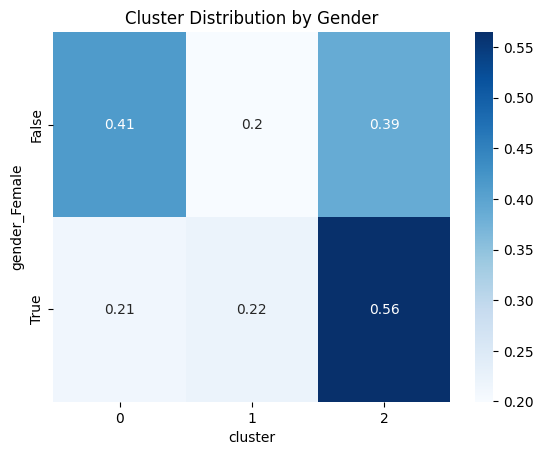


Bias Estimate: 0.034, Variance Estimate: 0.005


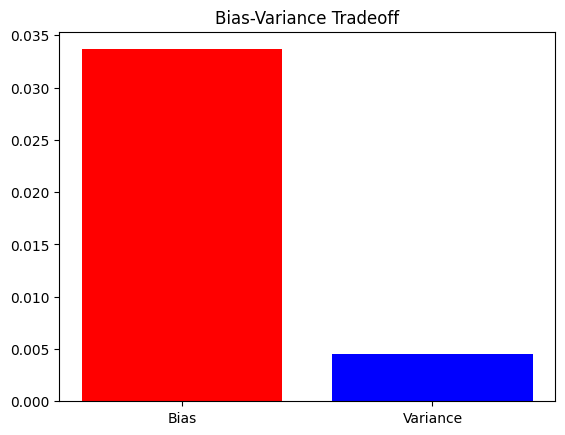


Fairness Mitigation Strategies:
- Rebalance dataset if one gender/zone is underrepresented
- Use fairness-aware metrics (equal opportunity, demographic parity)
- Apply reweighting or resampling to reduce bias impact
- Post-process model outputs (e.g., threshold adjustment)
- Monitor SHAP/LIME explanations to detect unfair influence of sensitive features


In [5]:
# fairness.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# ------------------------------
# 1. Load clustered partner data
# ------------------------------
import getpass

# ------------------------------
# 1. Load clustered partner data
# ------------------------------

# Use your macOS username (likely "tanisha") instead of postgres
username = getpass.getuser()   # dynamically picks your system username
password = 'NehaPriya29'                 # leave empty if no password is set
host = 'localhost'
port = 5432
database = 'Nova_project'

connection_str = f'postgresql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_str)

query = 'SELECT * FROM "Nova_Partner_Clustered"'
df = pd.read_sql(query, engine)

print("Dataset Shape:", df.shape)
df.head()
# -----------------------------
# 2. Check sensitive attributes
# -----------------------------

# Gender distribution (already one-hot encoded)
gender_counts = df[["gender_Female", "gender_Male"]].sum()
print("\nGender distribution:\n", gender_counts)

# Zone distribution (sum of one-hot encoded zone columns)
zone_cols = [col for col in df.columns if col.startswith("zone_")]
if zone_cols:
    zone_counts = df[zone_cols].sum()
    print("\nZone distribution:\n", zone_counts)

# Job type distribution (sum of one-hot encoded job_type columns)
jobtype_cols = [col for col in df.columns if col.startswith("job_type_")]
if jobtype_cols:
    job_counts = df[jobtype_cols].sum()
    print("\nJob Type distribution:\n", job_counts)

# -----------------------------
# 3. Bias Check: Group Analysis
# -----------------------------
# Example: Compare cluster assignments by gender
if "cluster" in df.columns:
    gender_bias = df.groupby(["gender_Female"])["cluster"].value_counts(normalize=True).unstack()
    print("\nCluster distribution by gender:\n", gender_bias)

    sns.heatmap(gender_bias, annot=True, cmap="Blues")
    plt.title("Cluster Distribution by Gender")
    plt.show()

# --------------------------------------------------
# 4. Bias-Variance Tradeoff Visualization (example)
# --------------------------------------------------
# Assume we want to see stability of predictions for fairness-sensitive groups

# Select features (drop IDs & cluster label)
X = df.drop(columns=["partner_id", "cluster"], errors="ignore")
y = df["cluster"] if "cluster" in df.columns else np.random.randint(0, 3, len(df))  # placeholder if no labels

rf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=cv)

bias = 1 - scores.mean()   # error = bias + variance
variance = scores.std()

print(f"\nBias Estimate: {bias:.3f}, Variance Estimate: {variance:.3f}")

plt.bar(["Bias", "Variance"], [bias, variance], color=["red", "blue"])
plt.title("Bias-Variance Tradeoff")
plt.show()

# -------------------------------------------------------
# 5. Document Fairness Mitigation Strategies (summary)
# -------------------------------------------------------
print("\nFairness Mitigation Strategies:")
print("- Rebalance dataset if one gender/zone is underrepresented")
print("- Use fairness-aware metrics (equal opportunity, demographic parity)")
print("- Apply reweighting or resampling to reduce bias impact")
print("- Post-process model outputs (e.g., threshold adjustment)")
print("- Monitor SHAP/LIME explanations to detect unfair influence of sensitive features")